# MPR121 Data Analysis Notebook
Author: Christopher Parker (parkecp@mail.uc.edu)

In [1]:
import os
from io import StringIO
import h5py
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as scs
import scipy.optimize as sco
from scipy.stats import pearsonr
import ipywidgets as widgets

In [2]:
# Load the data by filename
recording_filename = 'raw_data_2025-04-24_11-39-40.h5'

# Determine what date/time the recording was started (for
# use in saving figures later with the proper date/time)
recording_datetime = os.path.splitext(recording_filename)[0]
recording_datetime = recording_datetime.split('raw_data_')[1]

if not os.path.exists('Filtered Data Figures'):
    os.mkdir('Filtered Data Figures')
if not os.path.exists('Recording Figures'):
    os.mkdir('Recording Figures')

In [3]:
# Function to display layout when file is uploaded
def display_layout(*args):
    global sensor_animal_map
    # Convert the raw bytes loaded from the user upload into
    # a UTF-8 encoded string, then use io.StringIO to turn the
    # string back into a file. Kind of annoying that the FileUpload
    # widget gives a raw bytearray instead of a file handle,
    # but this works.
    string_ = str(file_upload.value[0].content.tobytes(), 'utf8')
    str_upload = StringIO(string_)
    # Print the layout from the uploaded file
    layout = pd.read_csv(str_upload, header=None, index_col=0)
    layout.index.name = 'Sensor'
    layout.columns = ['Animal ID']
    with layout_output:
        print(layout)
        sensor_animal_map = layout

In [4]:
# File upload widget for cage layouts
file_upload = widgets.FileUpload(
    accept='.csv',
    multiple=False,
    description='Upload cage layout CSV file',
    layout={'width':'300px'}
)
# Watch for the user to upload a file, then call the
# display function
file_upload.observe(display_layout, 'value')

# Organize and display the widgets
layout_output = widgets.Output()
layout_display_box = widgets.VBox([file_upload, layout_output])

display(layout_display_box)

In [5]:
data_dict = {}
# We only expect up to 3 nested levels based on the DataRecording notebook
with h5py.File(recording_filename, 'r') as h5f:
    for k,v in h5f.items():
        data_dict[k] = {} if isinstance(v, h5py._hl.group.Group) else v
        if not isinstance(data_dict[k], dict): continue
        for k2,v2 in v.items():
            data_dict[k][k2] = {} if isinstance(v2, h5py._hl.group.Group) else v2[()]
            if not isinstance(data_dict[k][k2], dict): continue
            for k3,v3 in v2.items():
                data_dict[k][k2][k3] = v3[()]
            #data_dict[k][k2] = v2[()]

In [6]:
# Loop through all boards and sensors and truncate at start_time and stop_time, then subtract the first time point from the data
for board_id, board_data in data_dict.items():
    for sensor_id, sensor_data in board_data.items():
        if 'start_time' not in sensor_data.keys():
            sensor_data['fs'] = len(sensor_data['cap_data'])/(sensor_data['time_data'][-1] - sensor_data['time_data'][0])
            continue
        else:
            start_idx = np.argmin(np.abs(sensor_data['time_data'] - sensor_data['start_time']))
            stop_idx = np.argmin(np.abs(sensor_data['time_data'] - sensor_data['stop_time']))
            
            if sensor_data['stop_time'] - sensor_data['start_time'] <= 1000:
                print(f"{board_id} {sensor_id} likely had a false start/stop, the stop time is less than 1000 seconds after start")

            sensor_data['time_data'] = sensor_data['time_data'][start_idx:stop_idx] - sensor_data['start_time']
            sensor_data['cap_data'] = sensor_data['cap_data'][start_idx:stop_idx]
            sensor_data['fs'] = (stop_idx - start_idx)/(sensor_data['stop_time'] - sensor_data['start_time'])
            
            if 'stop_vol' in sensor_data.keys():
                sensor_data['consumed_vol'] = sensor_data['start_vol'] - sensor_data['stop_vol']

In [7]:
# Reorganize the data to be by animal ID, agnostic wrt any board/sensor numbering
data_by_animal = {}
for idx,row in sensor_animal_map.iterrows():
    sensor = row.name
    animal = row.item()
    # We need to determine which FT232H was used for the recordings
    if sensor in [1,2,3,7,8,9]:
        board_id = 'board_FT232H0'
    elif sensor in [4,5,6,10,11,12]:
        board_id = 'board_FT232H1'
    elif sensor in [13,14,15,19,20,21]:
        board_id = 'board_FT232H2'
    elif sensor in [16,17,18,22,23,24]:
        board_id = 'board_FT232H3'
    try:
        data_by_animal[animal] = data_dict[board_id][f"sensor_{sensor}"]
    except KeyError as e:
        print(f"Missing key in data_dict: {e}")

In [8]:
data_by_animal['A7']['time_data'] = data_by_animal['A7']['time_data'][1000:]
data_by_animal['A7']['cap_data'] = data_by_animal['A7']['cap_data'][1000:]

for (animal, data) in data_by_animal.items():
    data['time_data'] = data['time_data'][:-250]
    data['cap_data'] = data['cap_data'][:-250]

In [9]:
# Trying a mix of using raw trace and Hilbert envelope to find licks
for (animal, data) in data_by_animal.items():
    if animal in ['A1', 'A2', 'A3', 'A4', 'A5', 'A6']: continue
    fs = data['fs']
    trace = data['cap_data']

    # 1a) 8–12 Hz band-pass
    bh, ah = scs.butter(2, 6, btype='high', fs=fs)
    bl, al = scs.butter(2, 14, btype='low', fs=fs)
    filtered_data = scs.filtfilt(bh, ah, trace)
    filtered_data = scs.filtfilt(bl, al, filtered_data)
    filtered_data = [scs.filtfilt(bh, ah, filtered_data) for _ in range(3)][-1]
    filtered_data = [scs.filtfilt(bl, al, filtered_data) for _ in range(3)][-1]

    # 1b) analytic signal → envelope
    env = np.abs(scs.hilbert(filtered_data))

    # 2) thresholding
    env_thr  = 0.4 * np.max(env)
    env_mask = env > env_thr

    # 3) Raw threshold crossings
    baseline = np.median(trace[:int(fs)])  
    depth    = baseline - np.min(trace)
    # raw_thr  = baseline - 0.4*depth     # tune the fraction

    # where we go from above → below the raw_thr
    downs = np.where((trace[:-1] > trace[1:]))[0] + 1

    # 4a) gate by envelope mask
    candidates = [i for i in downs if env_mask[i]]

    # 4b) enforce at least ~80 ms (0.08 s) between licks (mice shouldn't be licking faster than that)
    min_dist = int(0.08 * fs)
    lick_idxs = []
    for idx in candidates:
        if not lick_idxs or (idx - lick_idxs[-1]) > min_dist:
            lick_idxs.append(idx)

    # convert to timestamps
    lick_times = np.array(lick_idxs) / fs

    data['lick_times'] = lick_times
    data['lick_indices'] = lick_idxs

    # print(f"lick_times: {lick_times}")
    num_licks = len(lick_times)
    data['num_licks'] = num_licks
    print(f"length of lick_times: {num_licks}")


length of lick_times: 329
length of lick_times: 149
length of lick_times: 167
length of lick_times: 247
length of lick_times: 66
length of lick_times: 165
length of lick_times: 268
length of lick_times: 155
length of lick_times: 184
length of lick_times: 250
length of lick_times: 189
length of lick_times: 120
length of lick_times: 69
length of lick_times: 161
length of lick_times: 68
length of lick_times: 196
length of lick_times: 141
length of lick_times: 182


[Text(0.5, 1.0, 'A9')]

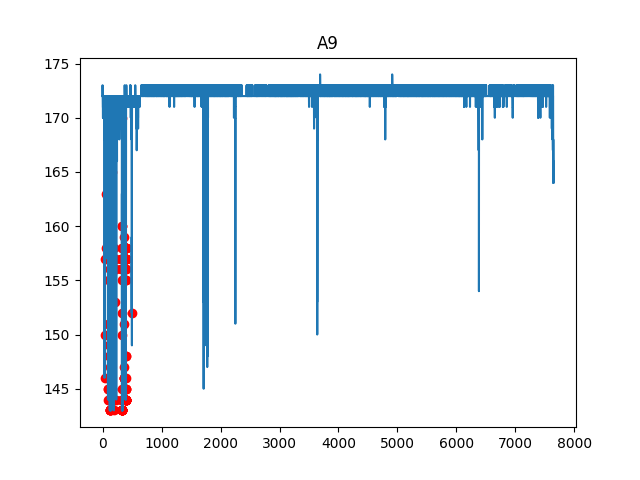

In [39]:
%matplotlib widget

# Make an interactive plot of a single animal's data
animal = 'A9'
masked_data = data_by_animal[animal]['cap_data'][data_by_animal[animal]['lick_indices']]
masked_time = data_by_animal[animal]['time_data'][data_by_animal[animal]['lick_indices']]

fig, ax = plt.subplots(nrows=1)
ax.plot(data_by_animal[animal]['time_data'], data_by_animal[animal]['cap_data'])
ax.scatter(masked_time, masked_data, c='red')
ax.set(title=animal)
# plt.savefig(f"Recording Figures/{animal}_recording_{recording_datetime}.png", dpi=300)
# plt.close(fig)

In [64]:
%matplotlib widget
# fig, axes = plt.subplots(nrows=len(data_by_animal.keys()), figsize=(10,10))
# plt.subplots_adjust(hspace=0.5)

for animal, data in data_by_animal.items():
    if animal in ['A1', 'A2', 'A3', 'A4', 'A5', 'A6']: continue
    lick_indices = data['lick_indices']
    masked_data = data['cap_data'][lick_indices]
    masked_time = data['time_data'][lick_indices]
    # masked_data = data['cap_data'][data['peaks']]
    # masked_time = data['time_data'][data['peaks']]
    
    fig, ax = plt.subplots(nrows=1)
    ax.plot(data['time_data'], data['cap_data'])
    ax.scatter(masked_time, masked_data, c='red')
    ax.set(title=animal)
    plt.savefig(f"Recording Figures/{animal}_recording_{recording_datetime}.png", dpi=300)
    plt.close(fig)

In [ ]:
%matplotlib widget
# fig, axes = plt.subplots(nrows=len(data_by_animal.keys()), figsize=(10,10))
# plt.subplots_adjust(hspace=0.5)

for animal, data in data_by_animal.items():
    if animal in ['A1', 'A2', 'A3', 'A4', 'A5', 'A6']: continue
    masked_data = data['cap_data'][data['peaks']]
    masked_time = data['time_data'][data['peaks']]
    
    fig, ax = plt.subplots(nrows=1)
    ax.plot(data['time_data'], data['cap_data'])
    ax.scatter(masked_time, masked_data, c='red')
    ax.set(title=animal)
    plt.savefig(f"Recording Figures/{animal}_recording_{recording_datetime}.png", dpi=300)
    plt.close(fig)

In [12]:
consumed_vols = []
licks = []
for animal, data in data_by_animal.items():
    if animal in ['A1', 'A2', 'A3', 'A4', 'A5', 'A6']: continue

    consumed_vols.append(data['consumed_vol'])
    licks.append(data['num_licks'])

In [13]:
res = pearsonr(consumed_vols, licks)

In [14]:
res.statistic

np.float64(0.6149719969652621)

In [27]:
res.statistic**2

np.float64(0.3781905570514423)